In [3]:
import itertools
import math
import os
import gsd.hoomd
import hoomd
import numpy
import warnings
import fresnel
import IPython
import packaging.version 
import matplotlib
import io 
import PIL
import freud
import matplotlib.pyplot as plt

%matplotlib inline 
matplotlib.style.use('ggplot')
import matplotlib_inline

matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

In [42]:
device = fresnel.Device()
tracer = fresnel.tracer.Path(device=device, w=300, h=300)

def render_2d(snapshot):

    L = snapshot.configuration.box[0]
    
    scene = fresnel.Scene(device)

    geometry = fresnel.geometry.Sphere(scene, N=len(snapshot.particles.position), radius=0.5)
    
    geometry.material = fresnel.material.Material(
        color=fresnel.color.linear([252 / 255, 209 / 255, 1 / 255]), roughness=0.5
    )
    
    positions_array = numpy.array(snapshot.particles.position)
    geometry.position[:, :2] = positions_array[:, :2]  
    geometry.outline_width = 0.04 
    
    fresnel.geometry.Box(scene, [L, L, 0], box_radius=0.02) 
    
    scene.camera = fresnel.camera.Orthographic.fit(scene)
    
    scene.background_alpha = 1
    scene.background_color = (1, 1, 1)
    
    return IPython.display.Image(tracer.sample(scene, samples=500)._repr_png_())

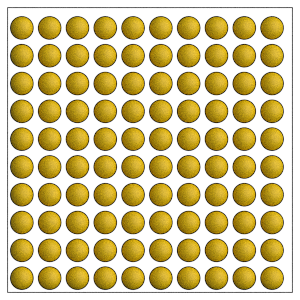

In [43]:
m = 10
N_particles = m ** 2
spacing = 1.2
K = math.ceil(N_particles ** (1/2))
L = K * spacing 
x = numpy.linspace(-L / 2 + spacing / 2, L / 1.9, K, endpoint=False)

position = list(itertools.product(x, x))

frame = gsd.hoomd.Frame()
frame.particles.N = len(position)  
frame.particles.position = numpy.hstack([numpy.array(position[0:N_particles]), numpy.zeros((N_particles, 1))])  
frame.particles.typeid = [0] * N_particles 
frame.configuration.box = [L, L, 0]

render_2d(frame)

In [46]:
fn = os.path.join(os.getcwd(), 'lattice.gsd')
![ -e "$fn" ] && rm "$fn"

frame = gsd.hoomd.Frame()
frame.particles.N = len(position)
# Ensure positions are in 3D (x, y, z) by appending zero z-coordinates
positions_2d = numpy.array(position[0:N_particles])  # 2D positions (x, y)
positions_3d = numpy.hstack([positions_2d, numpy.zeros((N_particles, 1))])  # Add z = 0 for each particle

frame.particles.position = positions_3d  # Assign to particle positions

frame.particles.typeid = [0] * N_particles
frame.particles.types = ['disks']
frame.configuration.box = [L, L, 0.01, 0, 0, 0]
with gsd.hoomd.open(name='lattice.gsd', mode='x') as f:
    f.append(frame)


In [61]:
cpu = hoomd.device.CPU()
simulation = hoomd.Simulation(device=cpu, seed=20)

mc = hoomd.hpmc.integrate.Sphere()

simulation.operations.integrator = mc
simulation.create_state_from_gsd(filename='lattice.gsd')

mc.shape['disks'] = dict(diameter=2)

In [62]:
initial_snapshot = simulation.state.get_snapshot()

In [66]:
simulation.run(10e5)

In [67]:
mc.overlaps

145398

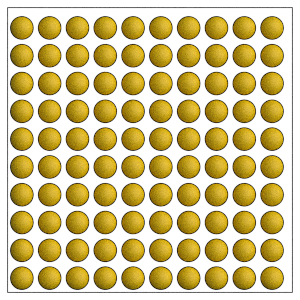

In [68]:
final_snapshot = simulation.state.get_snapshot()
render_2d(final_snapshot)


In [69]:
initial_snapshot.particles.position[0:4]

array([[-5.4000001 , -5.4000001 ,  0.        ],
       [-5.4000001 , -4.22842121,  0.        ],
       [-5.4000001 , -3.05684209,  0.        ],
       [-5.4000001 , -1.8852632 ,  0.        ]])

In [70]:
final_snapshot.particles.position[0:4]

array([[-5.4000001 , -5.4000001 ,  0.        ],
       [-5.4000001 , -4.22842121,  0.        ],
       [-5.4000001 , -3.05684209,  0.        ],
       [-5.4000001 , -1.8852632 ,  0.        ]])